In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow import keras

pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

C:\Users\michi\anaconda3\envs\annelies-bookings-bert\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()


In [3]:
df = pd.read_csv('Hotel_Reviews.csv')

In [4]:
df.tail()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
515733,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 Vienna Austria,168,8/30/2015,8.1,Atlantis Hotel Vienna,Kuwait,no trolly or staff to help you take the luggage to the room,14,2823,location,2,8,7.0,"[' Leisure trip ', ' Family with older children ', ' 2 rooms ', ' Stayed 5 nights ']",704 day,48.203745,16.335677
515734,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 Vienna Austria,168,8/22/2015,8.1,Atlantis Hotel Vienna,Estonia,The hotel looks like 3 but surely not 4,11,2823,Breakfast was ok and we got earlier check in,11,12,5.8,"[' Leisure trip ', ' Family with young children ', ' Standard Triple Room ', ' Stayed 2 nights ']",712 day,48.203745,16.335677
515735,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 Vienna Austria,168,8/19/2015,8.1,Atlantis Hotel Vienna,Egypt,The ac was useless It was a hot week in vienna and it only gave more hot air,19,2823,No Positive,0,3,2.5,"[' Leisure trip ', ' Family with older children ', ' 2 rooms ', ' Stayed 4 nights ', ' Submitted from a mobile device ']",715 day,48.203745,16.335677
515736,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 Vienna Austria,168,8/17/2015,8.1,Atlantis Hotel Vienna,Mexico,No Negative,0,2823,The rooms are enormous and really comfortable I believe that a family of 5 members could be more than comfy in these spaces,25,3,8.8,"[' Leisure trip ', ' Group ', ' Standard Triple Room ', ' Stayed 3 nights ']",717 day,48.203745,16.335677
515737,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 Vienna Austria,168,8/9/2015,8.1,Atlantis Hotel Vienna,Hungary,I was in 3rd floor It didn t work Free Wife,13,2823,staff was very kind,6,1,8.3,"[' Leisure trip ', ' Family with young children ', ' 2 rooms ', ' Stayed 2 nights ']",725 day,48.203745,16.335677


In [5]:
df.shape

(515738, 17)

In this notebook, we will try to predict `Reviewer_Score` for each review.

## Attempt 1: concatenate the negative and positive review + LSTM

The data has a positive review and a negative review. To summarise this into one text field, we will concatenate them, and use a rare word as separator ("cucumber" in this case).

This is obviously not an ideal strategy because of
* Result might be dependent on whether positive comes first, or negative comes first.
* If you first truncate the positive and negative reviews to a fixed length, then it might be possible that only one of the reviews is truncated. This introduces a bias towards to shorter review.


This code is partly inspired by the Coursera course "Sequence Models" by deeplearning.ai and more specifically by the programming assignment "Emojify".

## 1.1 Create train and test set

#### Explore length of positive and negative reviews

In [6]:
df['Review_Total_Negative_Word_Counts'].mean()

18.539450263505888

In [7]:
df['Review_Total_Positive_Word_Counts'].mean()

17.77645820164502

In [8]:
df[['Review_Total_Negative_Word_Counts', 'Review_Total_Positive_Word_Counts']].describe()

,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts
count,515738.000000,515738.000000
mean,18.539450,17.776458
std,29.690831,21.804185
min,0.000000,0.000000
25%,2.000000,5.000000
50%,9.000000,11.000000
75%,23.000000,22.000000
max,408.000000,395.000000


#### Truncate and concatenate the negative and positive review

In [9]:
max_len = 31 # The maximal length of the review (including the separator word, 
            #we will truncate the review so that this is the max length)
separator = ' cucumber '

In [10]:
def truncate_sentence(sentence, max_len):
    return ' '.join(sentence.strip().split(' ')[:max_len])

In [11]:
df = df.assign(pos_trunc=df['Positive_Review'].apply(truncate_sentence, max_len=max_len//2),
               neg_trunc=df['Negative_Review'].apply(truncate_sentence, max_len=max_len//2))

In [12]:
df.loc[2, 'Positive_Review']

' Location was good and staff were ok It is cute hotel the breakfast range is nice Will go back '

In [13]:
df.loc[2, 'pos_trunc']

'Location was good and staff were ok It is cute hotel the breakfast range is'

In [14]:
booking = df[['neg_trunc', 'pos_trunc', 'Reviewer_Score']]

In [15]:
booking = booking.assign(review=(booking['neg_trunc'] + separator + booking['pos_trunc']))

In [16]:
booking.head()

,neg_trunc,pos_trunc,Reviewer_Score,review
0,I am so angry that i made this post available via all possible sites i,Only the park outside of the hotel was beautiful,2.9,I am so angry that i made this post available via all possible sites i cucumber Only the park outside of the hotel was beautiful
1,No Negative,No real complaints the hotel was great great location surroundings rooms amenities and service Two,7.5,No Negative cucumber No real complaints the hotel was great great location surroundings rooms amenities and service Two
2,Rooms are nice but for elderly a bit difficult as most rooms are two story,Location was good and staff were ok It is cute hotel the breakfast range is,7.1,Rooms are nice but for elderly a bit difficult as most rooms are two story cucumber Location was good and staff were ok It is cute hotel the breakfast range is
3,My room was dirty and I was afraid to walk barefoot on the floor which,Great location in nice surroundings the bar and restaurant are nice and have a lovely,3.8,My room was dirty and I was afraid to walk barefoot on the floor which cucumber Great location in nice surroundings the bar and restaurant are nice and have a lovely
4,You When I booked with your company on line you showed me pictures of a,Amazing location and building Romantic setting,6.7,You When I booked with your company on line you showed me pictures of a cucumber Amazing location and building Romantic setting


In [17]:
booking[['review', 'Reviewer_Score']].head()

,review,Reviewer_Score
0,I am so angry that i made this post available via all possible sites i cucumber Only the park outside of the hotel was beautiful,2.9
1,No Negative cucumber No real complaints the hotel was great great location surroundings rooms amenities and service Two,7.5
2,Rooms are nice but for elderly a bit difficult as most rooms are two story cucumber Location was good and staff were ok It is cute hotel the breakfast range is,7.1
3,My room was dirty and I was afraid to walk barefoot on the floor which cucumber Great location in nice surroundings the bar and restaurant are nice and have a lovely,3.8
4,You When I booked with your company on line you showed me pictures of a cucumber Amazing location and building Romantic setting,6.7


#### Explore the length of the resulting review

In [18]:
def compute_length_review(row):
    return len(row['review'].split())

In [19]:
booking = booking.assign(len_review=booking.apply(compute_length_review, axis=1))

In [20]:
booking['len_review'].mean()

18.562500727113378

In [21]:
booking['len_review'].max()

31

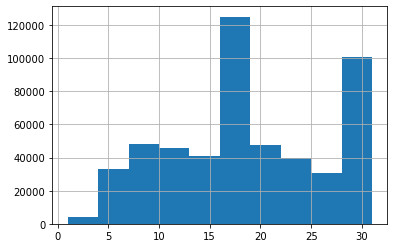

In [22]:
booking['len_review'].hist()
plt.show()

#### Split in train and test set

In [23]:
train, test = train_test_split(booking, test_size=0.3, random_state=0)

In [24]:
train.shape

(361016, 5)

In [25]:
test.shape

(154722, 5)

In [26]:
train.head()

,neg_trunc,pos_trunc,Reviewer_Score,review,len_review
62509,The reception is far away from clear always confused about what happened no ever when,Great location convenience to everywhere,5.4,The reception is far away from clear always confused about what happened no ever when cucumber Great location convenience to everywhere,21
336558,The tired wallpaper and carpets,The location and staff,9.2,The tired wallpaper and carpets cucumber The location and staff,10
106656,The d cor needs updating,Staff was helpful,6.3,The d cor needs updating cucumber Staff was helpful,9
60251,The fact that the kettle in the room was not emptied and the fact that,The comfort of the bed and the staff,7.9,The fact that the kettle in the room was not emptied and the fact that cucumber The comfort of the bed and the staff,24
245396,I was only there for an overnight stay but found no problems,I did not have breakfast at the hotel as I had to leave before the,9.2,I was only there for an overnight stay but found no problems cucumber I did not have breakfast at the hotel as I had to leave before the,28


## 1.2 Import word embedding

Download pre-trained glove word embedding from https://nlp.stanford.edu/projects/glove/. I used the one trained on Wikipedia 2014.

In [28]:
word_to_vector_dict = {}
with open("glove.6B.50d.txt", 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        word_to_vector_dict[word] = vector

In [29]:
# Make a token for unknown words
word_to_vector_dict['<unknown>'] = np.zeros_like(word_to_vector_dict['princess'])

In [32]:
word_to_index_dict = {}
i = 0

for word in word_to_vector_dict.keys():
    word_to_index_dict[word] = i
    i += 1

index_to_word_dict = {word_to_index_dict[k]: k for k in word_to_index_dict.keys()}
index_to_vector_dict = {i: word_to_vector_dict[index_to_word_dict[i]] for i in index_to_word_dict.keys()}

In [33]:
def sentences_to_indices(X, word_to_index_dict, max_len):
    """
    Converts an array of sentences (strings) into an array of indices.
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing each word mapped to its index
    max_len -- maximum number of words in a sentence.
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0] 
    X_indices = np.zeros((m, max_len))
    
    for i in range(m): 
        j = 0
        
        # Convert the ith training sentence in lower case and split it into words.
        sentence_words = X.iloc[i].lower().split()
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            if w not in word_to_index_dict.keys():
                w = '<unknown>'
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index_dict[w]
            # Increment j to j + 1
            j = j+1
    
    return X_indices

In [34]:
sentences_to_indices(pd.Series(booking.loc[0, 'review']), word_to_index_dict, max_len)

array([[4.1000e+01, 9.1300e+02, 1.0000e+02, 3.4000e+03, 1.2000e+01,
        4.1000e+01, 1.1600e+02, 3.7000e+01, 6.5800e+02, 7.7900e+02,
        1.9570e+03, 6.4000e+01, 5.5500e+02, 1.5580e+03, 4.1000e+01,
        2.9794e+04, 9.1000e+01, 0.0000e+00, 6.2500e+02, 5.8700e+02,
        3.0000e+00, 0.0000e+00, 1.2280e+03, 1.5000e+01, 3.3660e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [35]:
pd.Series(booking.loc[0, 'review'])

0    I am so angry that i made this post available via all possible sites i cucumber Only the park outside of the hotel was beautiful
dtype: object

## 1.3 Create model

In [38]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["cucumber"].shape[0]
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Define Keras embedding layer
    embedding_layer = keras.layers.Embedding(input_dim=vocab_len, output_dim=emb_dim, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [39]:
def build_model(max_len, word_to_vec_map, word_to_index):
    """
    Function creating the model's graph.
    
    Arguments:
    max_len -- maximal length of the sentences
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its vector representation
    word_to_index -- dictionary mapping words to their indices in the vocabulary

    Returns:
    model -- a model instance in Keras
    """
    
    sentence_indices = keras.Input(shape=(max_len,), dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through the embedding layer
    embeddings = embedding_layer(sentence_indices)  
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    layer = keras.layers.LSTM(units=128)(embeddings)
    # Propagate through a Dense layer with 1 units
    output = keras.layers.Dense(1)(layer)
    
    # Create Model instance which converts sentence_indices into the output.
    model = keras.models.Model(inputs=sentence_indices, outputs=output)
    
    return model

In [40]:
model = build_model(max_len, word_to_vector_dict, word_to_index_dict)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 31, 50)            20000100  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               91648     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 20,091,877
Trainable params: 91,777
Non-trainable params: 20,000,100
_________________________________________________________________


In [43]:
keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [44]:
model.compile(loss='mse', optimizer='adam')

In [45]:
train.head()

,neg_trunc,pos_trunc,Reviewer_Score,review,len_review
62509,The reception is far away from clear always confused about what happened no ever when,Great location convenience to everywhere,5.4,The reception is far away from clear always confused about what happened no ever when cucumber Great location convenience to everywhere,21
336558,The tired wallpaper and carpets,The location and staff,9.2,The tired wallpaper and carpets cucumber The location and staff,10
106656,The d cor needs updating,Staff was helpful,6.3,The d cor needs updating cucumber Staff was helpful,9
60251,The fact that the kettle in the room was not emptied and the fact that,The comfort of the bed and the staff,7.9,The fact that the kettle in the room was not emptied and the fact that cucumber The comfort of the bed and the staff,24
245396,I was only there for an overnight stay but found no problems,I did not have breakfast at the hotel as I had to leave before the,9.2,I was only there for an overnight stay but found no problems cucumber I did not have breakfast at the hotel as I had to leave before the,28


In [46]:
X_train_indices = sentences_to_indices(train['review'], word_to_index_dict, max_len)
Y_train = train['Reviewer_Score'].to_numpy()

In [47]:
X_train_indices.shape

(361016, 31)

In [48]:
Y_train.shape

(361016,)

In [49]:
Y_train

array([5.4, 9.2, 6.3, ..., 7.9, 9.2, 9.6])

In [50]:
train.iloc[2]['review']

'The d cor needs updating cucumber Staff was helpful'

In [51]:
X_train_indices[2]

array([0.0000e+00, 1.9680e+03, 4.2176e+04, 1.0750e+03, 2.0243e+04,
       2.9794e+04, 8.2100e+02, 1.5000e+01, 8.3470e+03, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00])

In [52]:
model.fit(x=X_train_indices, y=Y_train, epochs=10, batch_size=256, shuffle=True, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 288812 samples, validate on 72204 samples
Epoch 1/10
288812/288812 [==============================] - 72s 248us/sample - loss: 2.9263 - val_loss: 1.6954
Epoch 2/10
288812/288812 [==============================] - 69s 238us/sample - loss: 1.4699 - val_loss: 1.3567
Epoch 3/10
288812/288812 [==============================] - 65s 225us/sample - loss: 1.3301 - val_loss: 1.2882
Epoch 4/10
288812/288812 [==============================] - 70s 244us/sample - loss: 1.2724 - val_loss: 1.3164
Epoch 5/10
288812/288812 [==============================] - 66s 228us/sample - loss: 1.2347 - val_loss: 1.2519
Epoch 6/10
288812/288812 [==============================] - 65s 227us/sample - loss: 1.2036 - val_loss: 1.2113
Epoch 7/10
288812/288812 [==============================] - 65s 225us/sample - loss: 1.1803 - val_loss: 1.1838
Epoch 8/10
288812/288812 [==============================] - 64s 223us/sample -

In [53]:
model.save('model.h5')

In [54]:
def get_review_score(review, max_len):
    x_review = pd.Series([review])
    x_review_indices = sentences_to_indices(x_review, word_to_index_dict, max_len)
    score = model.predict(x_review_indices)[0][0]
    print(f'review: {review}')
    print(f'predicted score: {score}')
    return score

In [55]:
get_review_score('I hated staying here cucumber no positive', max_len)

review: I hated staying here cucumber no positive
predicted score: 5.936996936798096


5.936997

In [56]:
get_review_score('I hated staying here cucumber nothing', max_len)

review: I hated staying here cucumber nothing
predicted score: 3.9981560707092285


3.998156

In [57]:
get_review_score('Stupid hotel cucumber This hotel is great', max_len)

review: Stupid hotel cucumber This hotel is great
predicted score: 5.54572868347168


5.5457287

In [58]:
get_review_score('no negative cucumber This hotel is great', max_len)

review: no negative cucumber This hotel is great
predicted score: 9.252572059631348


9.252572

In [59]:
# Does it matter which word is the seperator?
get_review_score('no negative carrot This hotel is great', max_len)
get_review_score('no negative vegetable This hotel is great', max_len)
get_review_score('no negative donut This hotel is great', max_len)

review: no negative carrot This hotel is great
predicted score: 9.075560569763184
review: no negative vegetable This hotel is great
predicted score: 8.45508861541748
review: no negative donut This hotel is great
predicted score: 8.761009216308594


8.761009

In [60]:
# No seperator?
get_review_score('This hotel is great', max_len)

review: This hotel is great
predicted score: 8.394973754882812


8.394974

In [61]:
X_test_indices = sentences_to_indices(test['review'], word_to_index_dict, max_len)
Y_test = test['Reviewer_Score'].to_numpy()

In [62]:
test.iloc[0, :]['review']

'Very expensive Staff attitude was lacking cucumber No Positive'

In [63]:
index = 4
get_review_score(test.iloc[index, :]['review'], max_len)
print(f'actual score: {Y_test[index]}')

review: Boring breakfast for people from Asia especially for those who stay for more than 2 cucumber The proximity to the railway station right across the street Very convenient to reach all
predicted score: 8.221498489379883
actual score: 7.9


# Performance on test set

In [64]:
test.head()

,neg_trunc,pos_trunc,Reviewer_Score,review,len_review
276954,Very expensive Staff attitude was lacking,No Positive,5.0,Very expensive Staff attitude was lacking cucumber No Positive,9
231304,No Negative,Excellent location close to tube station Royal Albert Hall and the museums Good value for,8.8,No Negative cucumber Excellent location close to tube station Royal Albert Hall and the museums Good value for,18
247559,The lobby area is very small some staff could have been friendlier,The rooms are very quiet The breakfast was good The location is excellent it is,7.5,The lobby area is very small some staff could have been friendlier cucumber The rooms are very quiet The breakfast was good The location is excellent it is,28
432314,The lifts are painfully slow,Loved the roof top pool and bar area everything about it was beautiful Although it,9.2,The lifts are painfully slow cucumber Loved the roof top pool and bar area everything about it was beautiful Although it,21
453374,Boring breakfast for people from Asia especially for those who stay for more than 2,The proximity to the railway station right across the street Very convenient to reach all,7.9,Boring breakfast for people from Asia especially for those who stay for more than 2 cucumber The proximity to the railway station right across the street Very convenient to reach all,31


In [65]:
X_test_indices = sentences_to_indices(test['review'], word_to_index_dict, max_len)
Y_test = test['Reviewer_Score'].to_numpy()

In [67]:
predictions = model.predict(X_test_indices)

In [70]:
predictions.squeeze()

array([6.4670396, 9.449208 , 8.384199 , ..., 8.75643  , 8.787545 ,
       6.830998 ], dtype=float32)

In [69]:
Y_test

array([ 5. ,  8.8,  7.5, ...,  7.9, 10. ,  5. ])

In [81]:
print(f'mae: {mean_absolute_error(predictions.squeeze(), Y_test)}')
print(f'mse: {mean_squared_error(predictions.squeeze(), Y_test)}')

mae: 0.8098164912545183
mse: 1.1746928409176236


# Benchmark
Predict the average score on the training set

In [82]:
benchmark_predictions = np.ones(Y_test.shape) * train['Reviewer_Score'].mean()
print(f'mae: {mean_absolute_error(benchmark_predictions, Y_test)}')
print(f'mse: {mean_squared_error(benchmark_predictions, Y_test)}')

mae: 1.3152182385746745
mse: 2.684179954085147


We see that the model using glove does clearly better than the benchmark model.